### Вводные данные практической работы

Выполните следующие шаги:

1. Импортируйте все необходимые библиотеки.
2. Загрузите в рабочее пространство приложенные архивы: test.zip, train.zip.
Через программный код разархивируйте их. В итоге на трейне — шесть изображений и шесть масок, на тесте — два изображения и две маски, итого — 16 файлов.
3. Составьте две функции: прямую — перевод цвета маски в отметку сегментации и обратную — перевод отметки сегментации в цвет. Здесь вам понадобится словарь соответствия цветов сегментации и меток.
<pre>palette = {0 : (60, 16, 152), # Building
1 : (132, 41, 246), # Land
2 : (110, 193, 228), # Road
3 : (254, 221, 58), # Vegetation
4 : (226, 169, 41), # Water
5 : (155, 155, 155)} # Unlabeled </pre>
4. Входных снимков мало, поэтому придётся выполнить аугментацию трейна. Делать ли аугментацию теста — решать вам.
5. Подумайте, как стоит преобразовать входные и выходные данные, чтобы нейронная сеть могла лучше с ними работать. Выполните эти преобразования.
6. Выберите и создайте U-Net-модель (с помощью Keras или PyTorch).
7. Запустите обучение этой нейронной сети, подключив валидацию на тестовом множестве. Сохраните историю обучения в history_simple. Визуализируйте графики точности и потерь при обучении.
8. Визуализируйте предсказание сегментации на тестовом множестве. Выведите снимок, истинную маску, предсказанную маску на каждом тестовом примере.
9. Пользуясь transfer learning, создайте U-Net-модель с заморозкой энкодера.
10. Запустите обучение этой нейронной сети, подключив валидацию на тестовом множестве. Сохраните историю обучения в history_pretrained. Визуализируйте графики точности и потерь при обучении.
11. Визуализируйте предсказание сегментации на тестовом множестве. Выведите снимок, истинную маску, предсказанную маску на каждом тестовом примере.
12. Сделайте выводы:
* Какой вариант U-Net показал себя лучше?
* Какие подводные камни есть в этом решении?
* Общий вывод по работе в целом.
* По желанию. Выполните задачу с помощью обеих библиотек: Keras и PyTorch.


### 1. 2. Подключение библиотек, загрузка данных

In [1]:
import os
from PIL import Image
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, Conv2DTranspose
import random

import albumentations as A
import albumentations.augmentations.functional as F
import albumentations.augmentations.transforms
from albumentations.pytorch import ToTensorV2
import cv2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Извлечение данных из архивов

In [2]:
train_zip_path = 'train.zip'
test_zip_path = 'test.zip'

train_extract_path = 'train'
test_extract_path = 'test'

def unzip_data(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip_data(train_zip_path, train_extract_path)
unzip_data(test_zip_path, test_extract_path)

In [3]:
# Проверяем состав каталогов, чтобы убедиться в корректной распаковке архивов

train_images_path = os.listdir('train/train/images')
train_masks_path = os.listdir('train/train/masks')
test_images_path = os.listdir('test/test/images')
test_masks_path = os.listdir('test/test/masks')

print(f"Train Images: {len(train_images_path)}")
print(f"Train Masks: {len(train_masks_path)}")
print(f"Test Images: {len(test_images_path)}")
print(f"Test Masks: {len(test_masks_path)}")


Train Images: 7
Train Masks: 7
Test Images: 2
Test Masks: 2


### 3. Перевод цвета маски в отметку сегментации и перевод отметки сегментации в цвет

In [4]:
palette = {
    0: (60, 16, 152),   # Building
    1: (132, 41, 246),  # Land
    2: (110, 193, 228), # Road
    3: (254, 221, 58),  # Vegetation
    4: (226, 169, 41),  # Water
    5: (155, 155, 155)  # Unlabeled
}

def mask_to_class(mask):
    mask = np.array(mask)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    for class_index, color in palette.items():
        color = np.array(color)
        match = np.all(mask == color, axis=-1)
        label_mask[match] = class_index
    return label_mask


def class_to_mask(class_mask):
    h, w = class_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for class_index, color in palette.items():
        color_mask[class_mask == class_index] = color
    return color_mask

Проверка работы функций преобразования маски

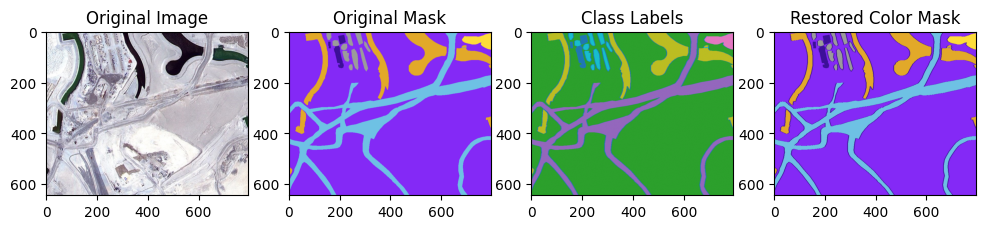

In [5]:
# Загружаем маску и изображение из train для отображения преобразований
mask_path = 'train/train/masks/0.png'
mask_img = Image.open(mask_path).convert('RGB')
#
demo_image_path = 'train/train/images/0.jpg'
demo_image= Image.open(demo_image_path)

# Преобразуем в метки классов
class_mask = mask_to_class(mask_img)

# Обратно в цветовую маску
restored_mask = class_to_mask(class_mask)

# Визуализируем исходное изображение и маску до и после преобразований
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(demo_image)

plt.subplot(1,4,2)
plt.title("Original Mask")
plt.imshow(mask_img)

plt.subplot(1,4,3)
plt.title("Class Labels")
plt.imshow(class_mask, cmap='tab10')

plt.subplot(1,4,4)
plt.title("Restored Color Mask")
plt.imshow(restored_mask)

plt.show()


Выведенный коллаж показывает, что маска соответствует изображению, а так же видим, что преобразования в мески классов и обратно выполняются корректно

### 4. 5. Аугментация и преобразование данных трейна

In [6]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Resize(256, 256),
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
val_transform = A.Compose([
    A.Resize(256, 256)
])

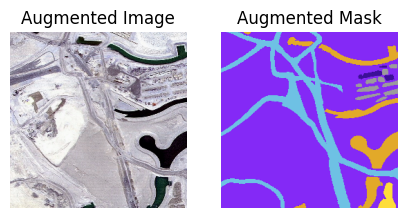

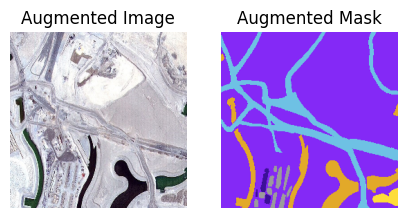

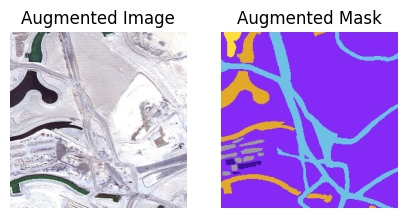

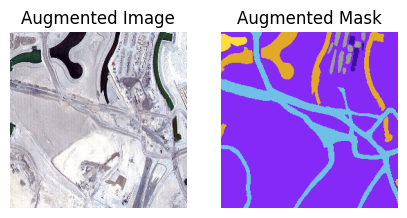

In [8]:
def visualize_augmentations(image_path, mask_path, transform, n=4):
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("RGB"))

    for i in range(n):
        augmented = transform(image=image, mask=mask)
        aug_img = augmented["image"]
        aug_mask = augmented["mask"]

        plt.figure(figsize=(5, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(aug_img)
        plt.title("Augmented Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(aug_mask)
        plt.title("Augmented Mask")
        plt.axis("off")
        plt.show()

# Пример визуализации аугментаций:
visualize_augmentations("train/train/images/0.jpg", "train/train/masks/0.png", train_transform)


In [9]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=2, augmentations=None, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.augmentations = augmentations
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        image_batch = []
        mask_batch = []

        for i in indexes:
            img = np.array(Image.open(self.image_paths[i]).convert("RGB"))
            mask = np.array(Image.open(self.mask_paths[i]).convert("RGB"))
            mask = mask_to_class(mask)

            if self.augmentations:
                augmented = self.augmentations(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

            # Normalize and expand dims
            img = img / 255.0
            mask = keras.utils.to_categorical(mask, num_classes=len(palette))

            image_batch.append(img)
            mask_batch.append(mask)

        return np.array(image_batch), np.array(mask_batch)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [10]:
train_img_dir = "train/train/images"
train_mask_dir = "train/train/masks"
test_img_dir = "test/test/images"
test_mask_dir = "test/test/masks"

train_images = sorted([os.path.join(train_img_dir, fname) for fname in os.listdir(train_img_dir)])
train_masks = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir)])

test_images = sorted([os.path.join(test_img_dir, fname) for fname in os.listdir(test_img_dir)])
test_masks = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir)])

train_gen = DataGenerator(train_images, train_masks, batch_size=2, augmentations=train_transform)
val_gen = DataGenerator(test_images, test_masks, batch_size=1, augmentations=val_transform, shuffle=False)


### 6. 7. Cоздание U-Net-модели (Tensorflow.Keras), обучение нейросети

In [11]:
# Для удобства заранее создаем блоки свертки, энкодера и декодера для дальнейшей сборки из них U-Net модели
def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


In [12]:
# Создаем классическую конфигурацию U-Net модели из заранее прописанных блоков свертки, энкодера и декодера
def build_unet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = keras.Model(inputs, outputs, name="U-Net")
    return model


In [13]:
input_shape = (256, 256, 3)
num_classes = len(palette)

model = build_unet(input_shape, num_classes)

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,622 (118.47 MB)

 Trainable params: 31,043,846 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Модель создается корректно, по выводу summary видим ее структуру, можем переходить к ее обучению на трейне с применением аугментаций

In [14]:
# Колбэк для сохранения модели с наименьшей валидационной потерей
checkpoint = keras.callbacks.ModelCheckpoint("unet_simple.keras",
                                             save_best_only=True,
                                             verbose=1)

# Колбэк для ранней остановки в случае если валидационные потери не уменьшаются несколько эпох подряд
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history_simple = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.4073 - loss: 1.6492 
Epoch 1: val_loss improved from inf to 1.69341, saving model to unet_simple.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 17s/step - accuracy: 0.4283 - loss: 1.6088 - val_accuracy: 0.5878 - val_loss: 1.6934
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6010 - loss: 1.0873 
Epoch 2: val_loss did not improve from 1.69341
4/4 ━━━━━━━━━━━━━━━━━━━━ 58s 14s/step - accuracy: 0.6082 - loss: 1.0704 - val_accuracy: 0.0534 - val_loss: 8.7596
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7122 - loss: 0.8605 
Epoch 3: val_loss did not improve from 1.69341
4/4 ━━━━━━━━━━━━━━━━━━━━ 57s 14s/step - accuracy: 0.7070 - loss: 0.8648 - val_accuracy: 0.1752 - val_loss: 1.7639
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7110 - loss: 0.8609 
Epoch 4: val_loss did not improve from 1.69341
4/4 ━━━━━━━━━━━━━━━━━━━━ 60s 15s/step - accuracy: 0.7088 - loss: 0.8604 - val_accuracy: 0.0726 - val_lo

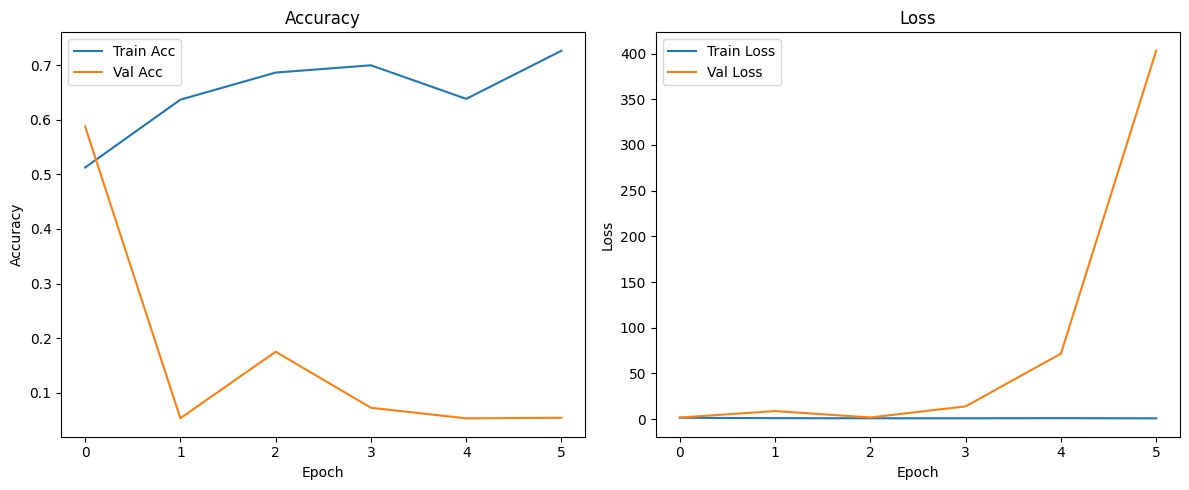

In [15]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Визуализация
plot_training_history(history_simple)


Как видим из граффика, модель показывает плохой результат, не особенно стабильно обучается, сказывается недостаточное количество обучающих данных, несмотря на все добавленные аугментации

### Визуализация графика точности и потерь при обучении, визуализация предсказания

In [16]:
def predict_and_visualize(model, test_image_paths, test_mask_paths, num_samples=2):
    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Загрузка и масштабирование изображения
        original_image = Image.open(test_image_paths[i]).convert("RGB")  # Преобразуем в RGB
        original_mask = Image.open(test_mask_paths[i]).convert("RGB")  # Преобразуем маску в RGB

        # Ресайз до нужного размера модели (256x256)
        image_resized = np.array(original_image.resize((256, 256))) / 255.0  # Форма: (256, 256, 3)
        mask_resized = np.array(original_mask.resize((256, 256), Image.NEAREST))

        # Преобразование маски в метки классов
        mask_resized = mask_to_class(mask_resized)  # Преобразуем RGB маску в метки (256, 256)

        # Предсказание
        input_tensor = np.expand_dims(image_resized, axis=0)  # Форма: (1, 256, 256, 3)
        pred = model.predict(input_tensor)[0]  # Предсказание модели
        pred_mask = np.argmax(pred, axis=-1)  # Форма: (256, 256)

        # Обратный перевод в цвет
        def decode_mask(mask):
            out = np.zeros((*mask.shape, 3), dtype=np.uint8)  # Форма: (256, 256, 3)
            for cls, color in palette.items():
                out[mask == cls] = color
            return out

        pred_colored = decode_mask(pred_mask)  # Форма: (256, 256, 3)
        true_colored = decode_mask(mask_resized)  # Форма: (256, 256, 3)

        # Отображение
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(image_resized)  # Форма (256, 256, 3) — корректно для RGB
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(true_colored)  # Форма: (256, 256, 3)
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(pred_colored)  # Форма: (256, 256, 3)
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [17]:
test_image_dir = os.path.join("test", "test", "images")
test_mask_dir = os.path.join("test", "test", "masks")

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith('.jpg')])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir) if fname.endswith('.png')])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


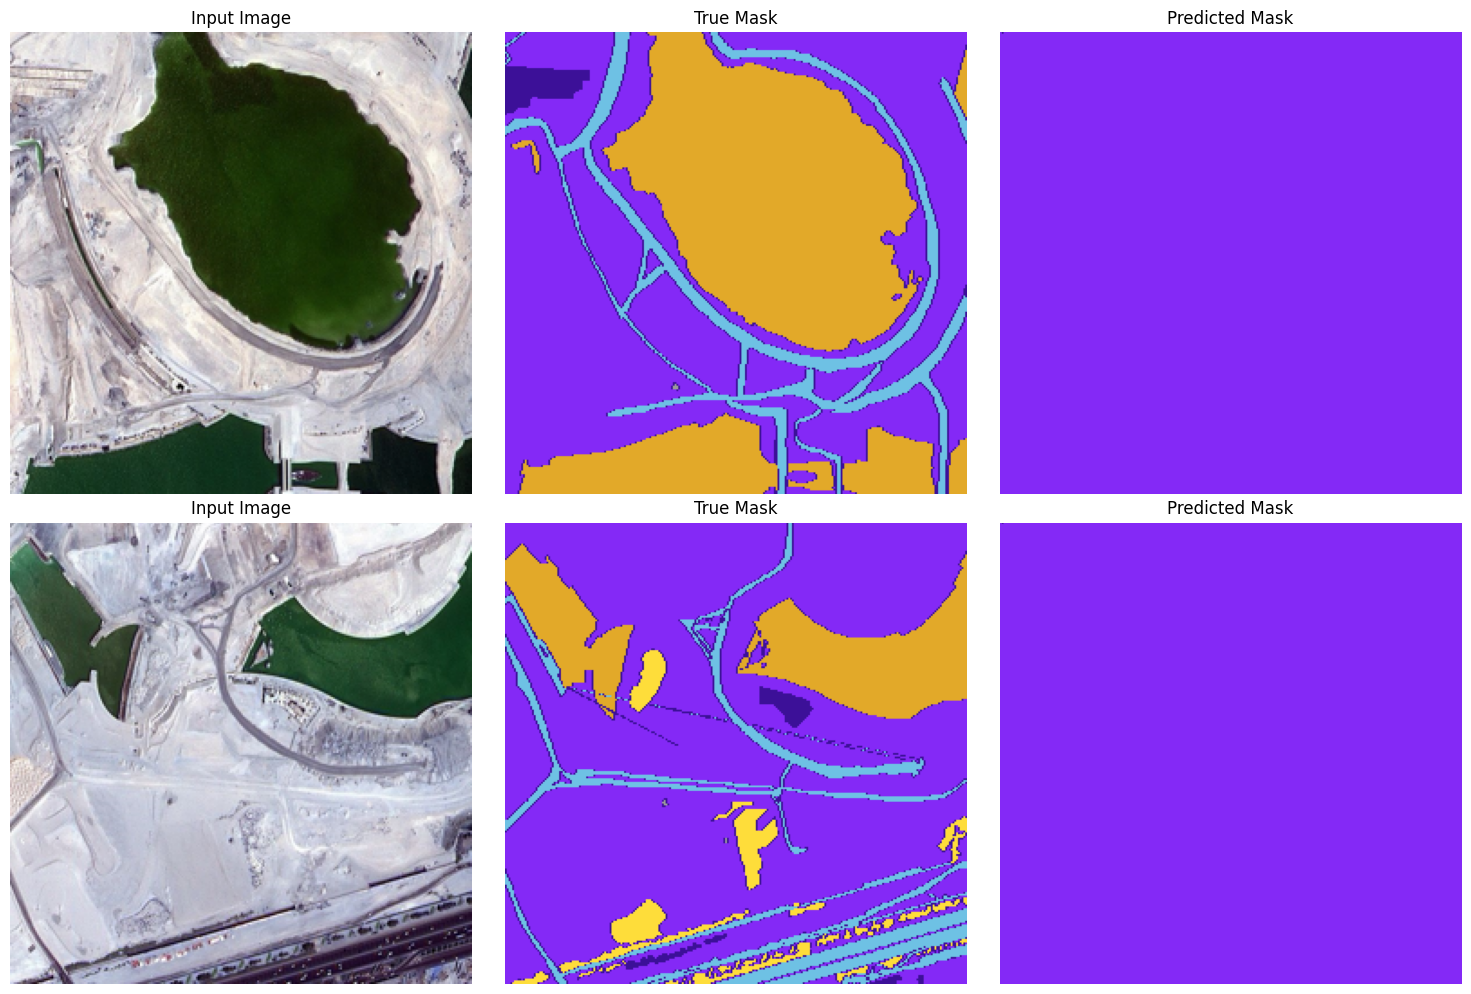

In [18]:
predict_and_visualize(model, test_image_paths, test_mask_paths, num_samples=2)

отображаемое предсказание показывает что нейросеть с задачей не справилась совсем

### 9. Transfer learning, предобученная U-Net-модель с заморозкой энкодера.

In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [26]:
def build_pretrained_unet(input_shape=(256, 256, 3), num_classes=6):
    # Загружаем предобученную VGG16 без верхних слоёв (включаем только энкодер)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Замораживаем слои энкодера
    for layer in base_model.layers:
        layer.trainable = False

    # Энкодер (выходы из блоков VGG16)
    encoder_outputs = [
        base_model.get_layer('block1_conv2').output,  # 256 фильтров
        base_model.get_layer('block2_conv2').output,  # 128 фильтров
        base_model.get_layer('block3_conv3').output,  # 64 фильтров
        base_model.get_layer('block4_conv3').output   # 32 фильтров
    ]
    input_layer = base_model.input

    x = encoder_outputs[-1]  # Начинаем с последнего блока энкодера

    # Уменьшаем количество фильтров для декодера
    for i, skip in enumerate(encoder_outputs[-2::-1]):  # Идём в обратном порядке
        x = Conv2DTranspose(512 // (2 ** i), (2, 2), strides=(2, 2), padding='same')(x)
        x = Concatenate()([x, skip])
        x = Conv2D(512 // (2 ** (i + 1)), 3, activation='relu', padding='same')(x)
        x = Conv2D(512 // (2 ** (i + 1)), 3, activation='relu', padding='same')(x)

    outputs = Conv2D(num_classes, 1, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=outputs, name='Pretrained_U-Net')
    return model

pretrained_model = build_pretrained_unet(input_shape=(256, 256, 3), num_classes=len(palette))
pretrained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pretrained_model.summary()

Model: "Pretrained_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer_5[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 64, 64,    │  1,049,088 │ block4_conv3[0][… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 768)              │            │ block3_conv3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │  1,769,728 │ concatenate_10[0

 Total params: 12,110,278 (46.20 MB)

 Trainable params: 4,475,014 (17.07 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### 10. TransferLearning. Обучение предобученной нейронной сети, подключив валидацию на тестовом множестве

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3572 - loss: 2.2704
Epoch 1: val_loss improved from inf to 1.32747, saving model to unet_pretrained.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 11s/step - accuracy: 0.3679 - loss: 2.2578 - val_accuracy: 0.5873 - val_loss: 1.3275
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6696 - loss: 1.0553 
Epoch 2: val_loss improved from 1.32747 to 1.17755, saving model to unet_pretrained.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 13s/step - accuracy: 0.6557 - loss: 1.0782 - val_accuracy: 0.5706 - val_loss: 1.1775
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6167 - loss: 1.1535 
Epoch 3: val_loss improved from 1.17755 to 0.93560, saving model to unet_pretrained.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 12s/step - accuracy: 0.6118 - loss: 1.1522 - val_accuracy: 0.6238 - val_loss: 0.9356
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6532 - loss: 0.9632 
Epoch 4: val_loss improved from 0.93560 to 0.72548, saving mod

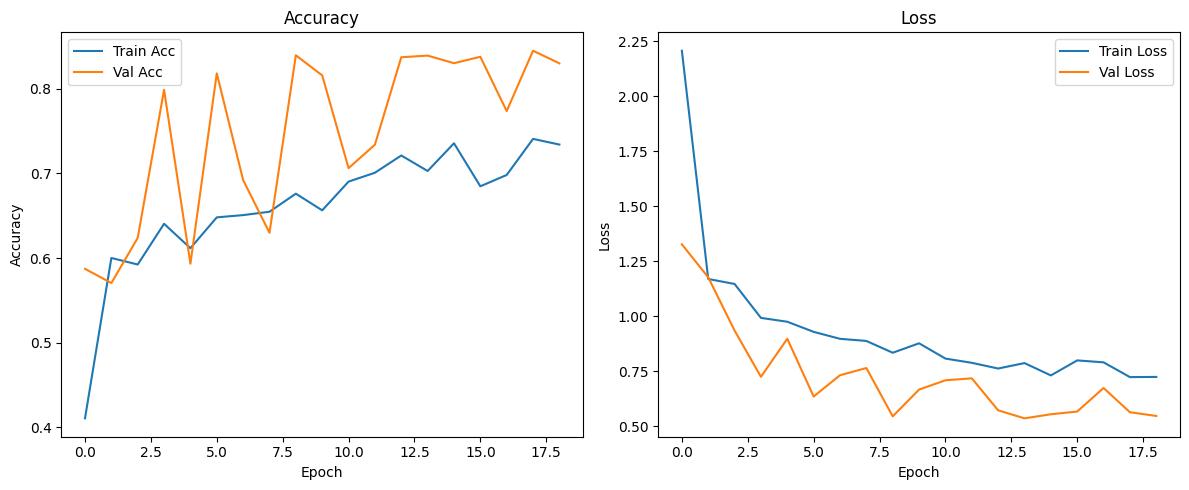

In [27]:
checkpoint = keras.callbacks.ModelCheckpoint("unet_pretrained.keras",
                                             save_best_only=True,
                                             verbose=1)
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history_pretrained = pretrained_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)
plot_training_history(history_pretrained)

### 11. Визуализация предсказания сегментации на тестовом множестве

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


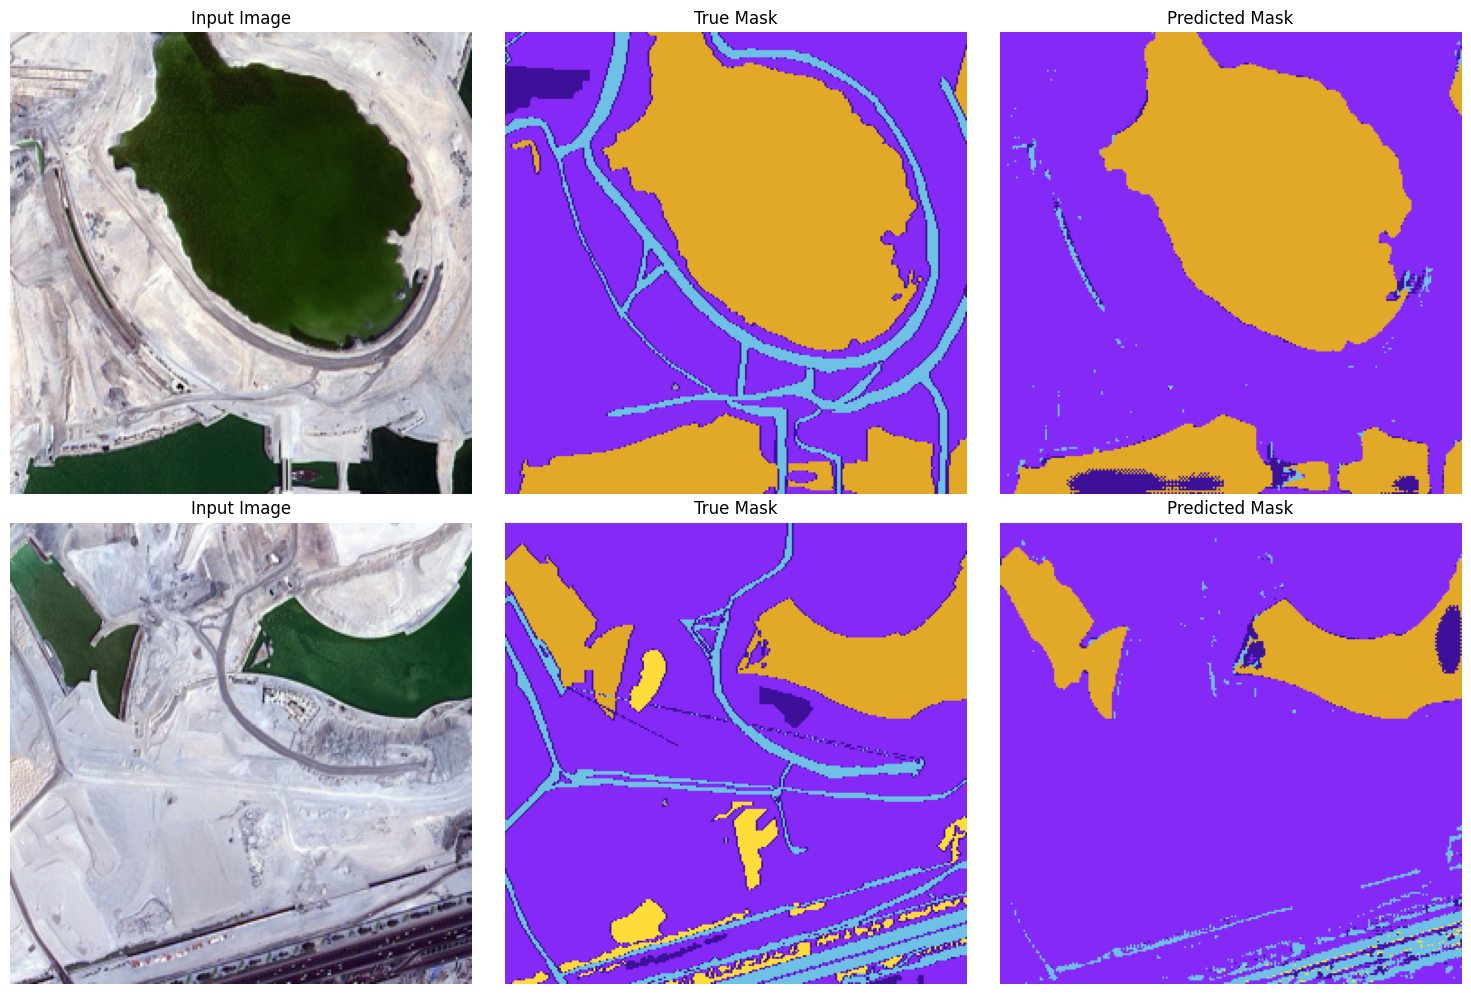

In [28]:
predict_and_visualize(pretrained_model, test_image_paths, test_mask_paths, num_samples=2)

### Выводы

Сравнивая графики точности и потерь (history_simple и history_pretrained), а так же визуализацию предсказания, можно сказать, что предобученная модель (с VGG16) показывает на порядок более лучшее обобщение благодаря извлечению признаков из ImageNet.
Выводы по порядку:

* 6 тренировочных изображений недостаточно для обучения сложной модели вроде U-Net, даже с аугментацией
* все изображения ресайзятся до 256x256, что в случае со спутниковыми снимками и городскими пейзажами может приводить к потере деталей, важных для сегментации

Использование аугментации и transfer learning помогает справляться с ограниченным объёмом данных, но результаты ограничены в случае совсем малого размера датасета и вероятнее всего не позволит использовать такую модель в реальных задачах. Для улучшения нужно увеличить количество данных, например, сгенерировать синтетические изображения или использовать более сложные аугментации.